# 05. Final Evaluation & Summary

## Muc tieu
- Tong hop ket qua tat ca models
- Danh gia chi tiet best model
- Tao cac bieu do cho bao cao
- Xuat final model de ung dung

In [29]:
# Import thu vien
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    roc_curve, precision_recall_curve
)

import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

## 1. Load du lieu va models

In [30]:
# Load du lieu test
X_test = np.load('data/X_test.npy')
y_test = np.load('data/y_test.npy')
feature_names = np.load('data/feature_names.npy', allow_pickle=True)

print(f"Test set: {X_test.shape}")

# Load ket qua
single_results = pd.read_csv('outputs/single_models_results.csv', index_col=0)
ensemble_results = pd.read_csv('outputs/ensemble_models_results.csv', index_col=0)
ablation_results = pd.read_csv('outputs/ablation_results.csv', index_col=0)

# Tim best model dua tren F1 score
# Loc bo 'Best Single Model' neu co
ensemble_clean = ensemble_results[ensemble_results.index != 'Best Single Model']
best_ensemble_name = ensemble_clean['f1'].idxmax()
best_single_name = single_results['f1'].idxmax()

# So sanh F1 cua ensemble tot nhat voi single tot nhat
if ensemble_clean.loc[best_ensemble_name, 'f1'] >= single_results.loc[best_single_name, 'f1']:
    best_model_file = f'models/ensemble_{best_ensemble_name.lower()}.pkl'
    best_name = best_ensemble_name
else:
    best_model_file = f'models/single_{best_single_name.lower()}.pkl'
    best_name = best_single_name

best_model = joblib.load(best_model_file)
print(f"Best model: {best_name} (loaded from {best_model_file})")


Test set: (10296, 14)
Best model: Stacking_Single (loaded from models/ensemble_stacking_single.pkl)


## 2. Tong hop ket qua tat ca Models

In [31]:
# Ket hop single va ensemble results
single_results['type'] = 'Single'
ensemble_clean = ensemble_results[ensemble_results.index != 'Best Single Model'].copy()
ensemble_clean['type'] = 'Ensemble'

all_results = pd.concat([single_results, ensemble_clean])
all_results = all_results.sort_values('f1', ascending=False)

print("TONG HOP KET QUA TAT CA MODELS:")
print("="*80)
print(all_results[['type', 'accuracy', 'recall', 'f1', 'roc_auc']].to_string())

TONG HOP KET QUA TAT CA MODELS:
                        type  accuracy  recall      f1  roc_auc
Stacking_Single     Ensemble    0.7316  0.7048  0.7221   0.7982
SGD                   Single    0.7274  0.7081  0.7199      NaN
DecisionTree          Single    0.7253  0.7130  0.7198   0.7811
XGBoost             Ensemble    0.7341  0.6885  0.7192   0.7998
Blending            Ensemble    0.7329  0.6906  0.7190   0.7998
NystroemSGD         Ensemble    0.7281  0.7020  0.7187      NaN
BaggingSVM          Ensemble    0.7330  0.6885  0.7184   0.7924
Stacking            Ensemble    0.7321  0.6904  0.7183   0.7999
MLP                   Single    0.7288  0.6985  0.7182   0.7979
HardVoting          Ensemble    0.7332  0.6865  0.7180      NaN
LightGBM            Ensemble    0.7325  0.6865  0.7175   0.7996
SoftVoting          Ensemble    0.7321  0.6855  0.7169   0.7997
RandomForest        Ensemble    0.7291  0.6818  0.7135   0.7971
KNN                   Single    0.7201  0.6841  0.7075   0.7814
Logistic

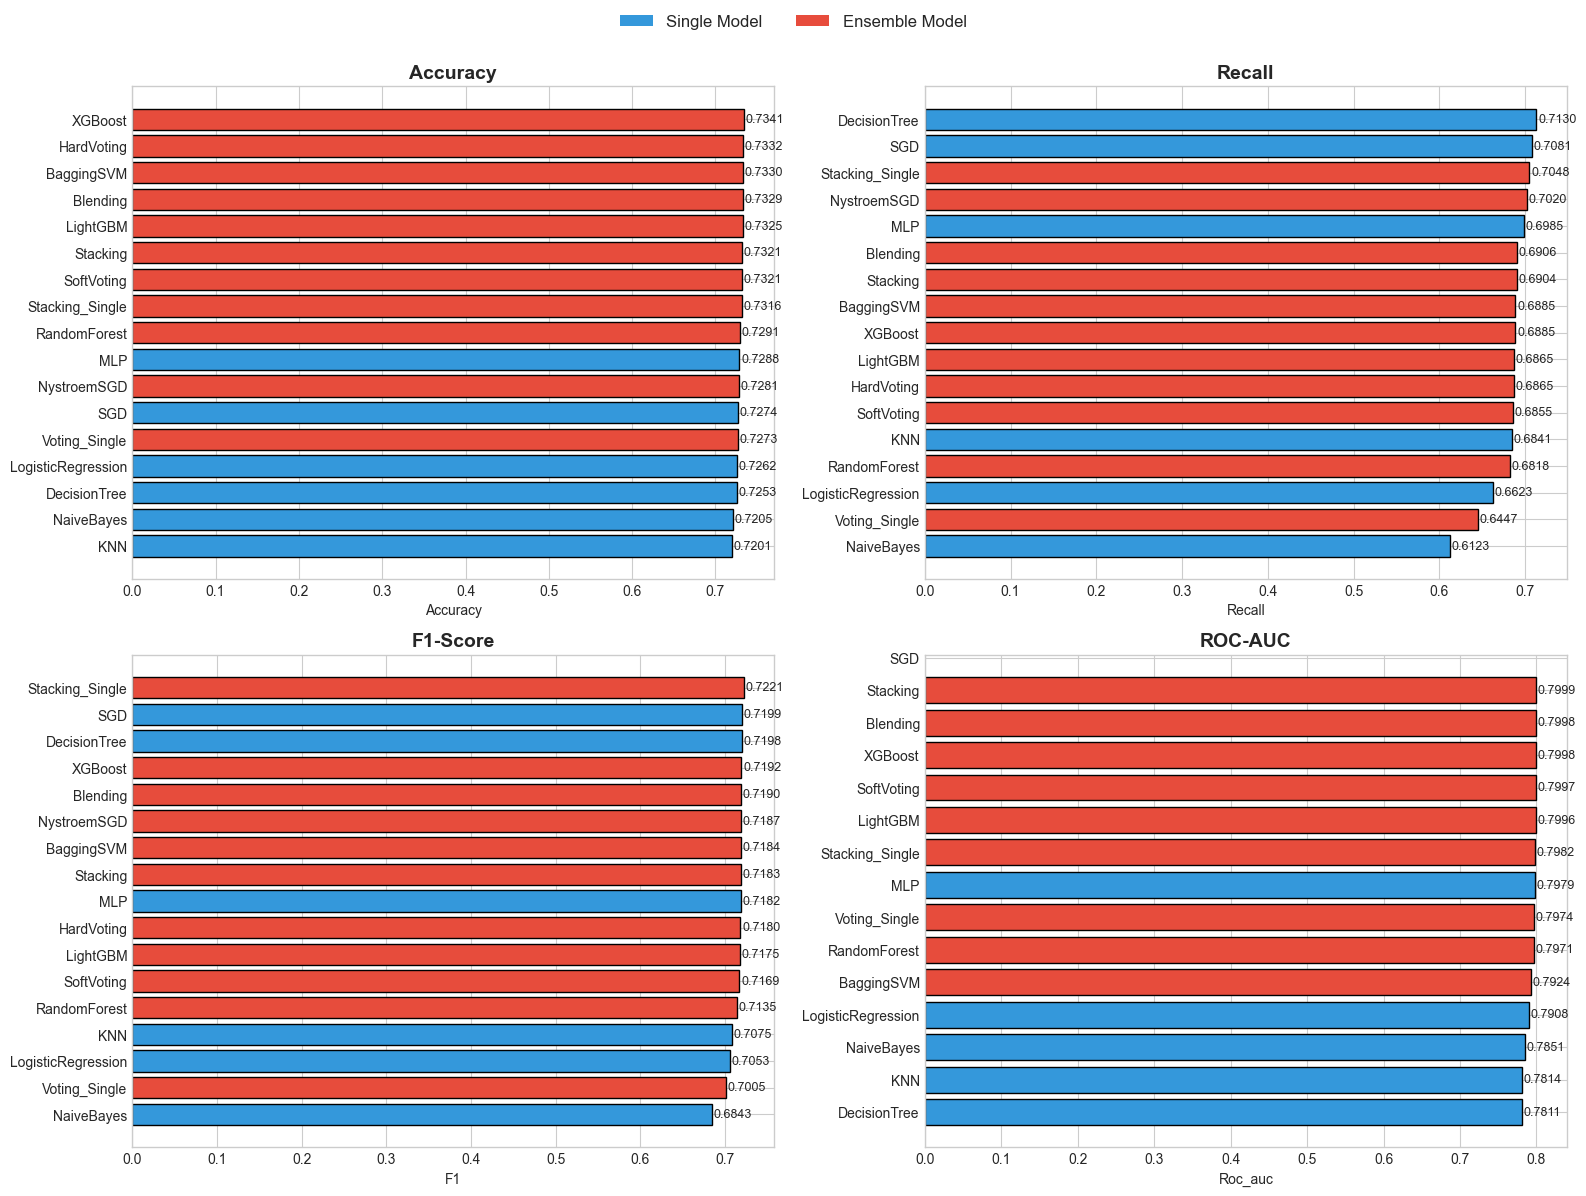

In [32]:
# Visualization tong hop
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

metrics = ['accuracy', 'recall', 'f1', 'roc_auc']
titles = ['Accuracy', 'Recall', 'F1-Score', 'ROC-AUC']

for i, (metric, title) in enumerate(zip(metrics, titles)):
    ax = axes[i // 2, i % 2]
    
    # Sort theo metric
    sorted_results = all_results.sort_values(metric, ascending=True)
    
    # Mau theo type
    colors = ['#e74c3c' if t == 'Ensemble' else '#3498db' for t in sorted_results['type']]
    
    bars = ax.barh(sorted_results.index, sorted_results[metric], color=colors, edgecolor='black')
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel(metric.capitalize())
    
    # Them gia tri
    for bar, val in zip(bars, sorted_results[metric]):
        if pd.notna(val):
            ax.text(val + 0.002, bar.get_y() + bar.get_height()/2, 
                    f'{val:.4f}', va='center', fontsize=9)

# Legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#3498db', label='Single Model'),
    Patch(facecolor='#e74c3c', label='Ensemble Model')
]
fig.legend(handles=legend_elements, loc='upper center', ncol=2, fontsize=12)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('outputs/17_all_models_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

## 3. Danh gia chi tiet Best Model

In [33]:
# Predict voi best model
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

# Tim ten best model
best_name = ensemble_results['f1'].idxmax()
if best_name == 'Best Single Model':
    best_name = single_results['f1'].idxmax()

print(f"\nBEST MODEL: {best_name}")
print("="*60)


BEST MODEL: Stacking_Single


In [34]:
# Classification Report chi tiet
print("\nCLASSIFICATION REPORT:")
print("-"*60)
print(classification_report(y_test, y_pred, target_names=['Khong benh', 'Co benh tim']))


CLASSIFICATION REPORT:
------------------------------------------------------------
              precision    recall  f1-score   support

  Khong benh       0.72      0.76      0.74      5202
 Co benh tim       0.74      0.70      0.72      5094

    accuracy                           0.73     10296
   macro avg       0.73      0.73      0.73     10296
weighted avg       0.73      0.73      0.73     10296



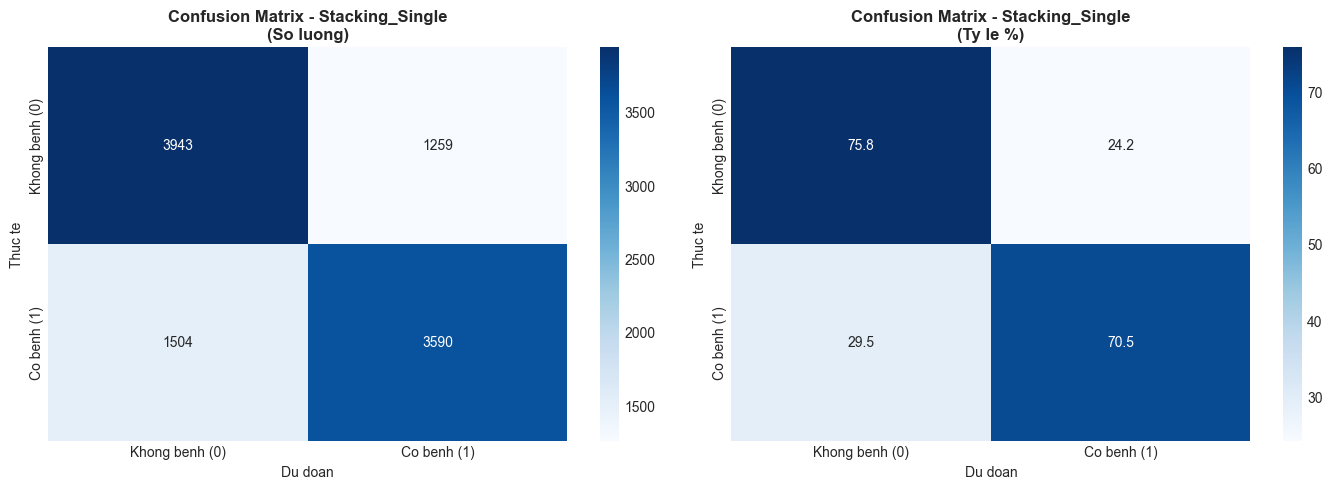


PHAN TICH CONFUSION MATRIX:
  True Negative (TN):  3,943 - Du doan dung nguoi khong benh
  False Positive (FP): 1,259 - Du doan nham nguoi khoe la benh
  False Negative (FN): 1,504 - Bo sot nguoi benh (NGUY HIEM!)
  True Positive (TP):  3,590 - Du doan dung nguoi benh


In [35]:
# Confusion Matrix chi tiet
cm = confusion_matrix(y_test, y_pred)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Raw counts
ax1 = axes[0]
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1,
            xticklabels=['Khong benh (0)', 'Co benh (1)'],
            yticklabels=['Khong benh (0)', 'Co benh (1)'])
ax1.set_title(f'Confusion Matrix - {best_name}\n(So luong)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Thuc te')
ax1.set_xlabel('Du doan')

# Percentages
ax2 = axes[1]
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
sns.heatmap(cm_percent, annot=True, fmt='.1f', cmap='Blues', ax=ax2,
            xticklabels=['Khong benh (0)', 'Co benh (1)'],
            yticklabels=['Khong benh (0)', 'Co benh (1)'])
ax2.set_title(f'Confusion Matrix - {best_name}\n(Ty le %)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Thuc te')
ax2.set_xlabel('Du doan')

plt.tight_layout()
plt.savefig('outputs/18_best_model_confusion.png', dpi=150, bbox_inches='tight')
plt.show()

# Phan tich confusion matrix
tn, fp, fn, tp = cm.ravel()
print(f"\nPHAN TICH CONFUSION MATRIX:")
print(f"  True Negative (TN):  {tn:,} - Du doan dung nguoi khong benh")
print(f"  False Positive (FP): {fp:,} - Du doan nham nguoi khoe la benh")
print(f"  False Negative (FN): {fn:,} - Bo sot nguoi benh (NGUY HIEM!)")
print(f"  True Positive (TP):  {tp:,} - Du doan dung nguoi benh")

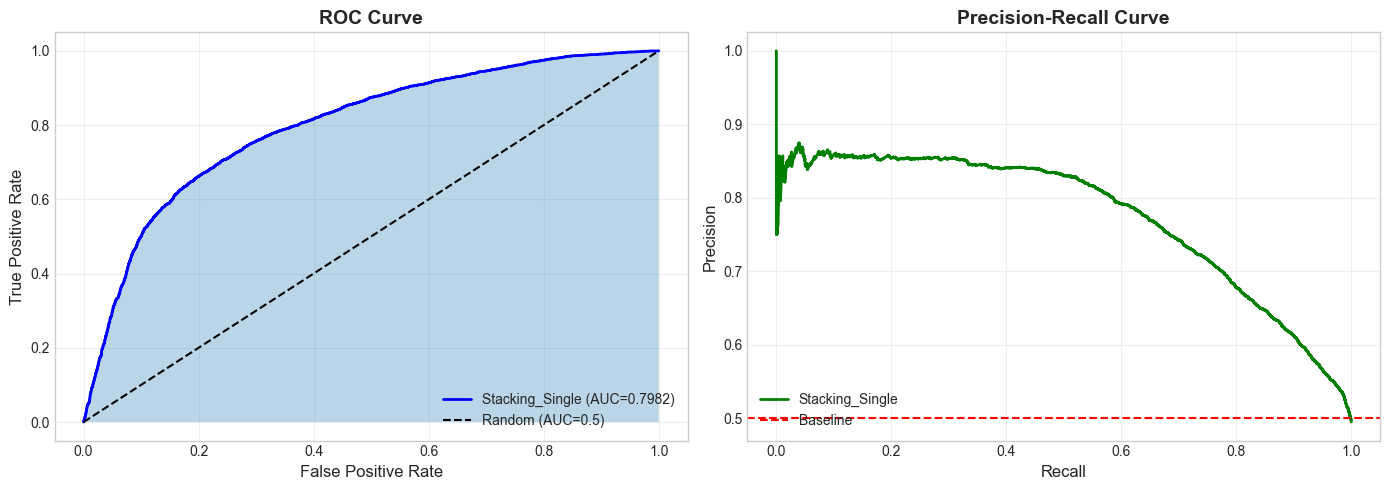

In [36]:
# ROC Curve va Precision-Recall Curve
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ROC Curve
ax1 = axes[0]
fpr, tpr, thresholds_roc = roc_curve(y_test, y_proba)
auc = roc_auc_score(y_test, y_proba)

ax1.plot(fpr, tpr, 'b-', linewidth=2, label=f'{best_name} (AUC={auc:.4f})')
ax1.plot([0, 1], [0, 1], 'k--', label='Random (AUC=0.5)')
ax1.fill_between(fpr, tpr, alpha=0.3)
ax1.set_xlabel('False Positive Rate', fontsize=12)
ax1.set_ylabel('True Positive Rate', fontsize=12)
ax1.set_title('ROC Curve', fontsize=14, fontweight='bold')
ax1.legend(loc='lower right')
ax1.grid(True, alpha=0.3)

# Precision-Recall Curve
ax2 = axes[1]
precision_curve, recall_curve, thresholds_pr = precision_recall_curve(y_test, y_proba)

ax2.plot(recall_curve, precision_curve, 'g-', linewidth=2, label=best_name)
ax2.axhline(y=0.5, color='red', linestyle='--', label='Baseline')
ax2.set_xlabel('Recall', fontsize=12)
ax2.set_ylabel('Precision', fontsize=12)
ax2.set_title('Precision-Recall Curve', fontsize=14, fontweight='bold')
ax2.legend(loc='lower left')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('outputs/19_best_model_curves.png', dpi=150, bbox_inches='tight')
plt.show()

## 4. Phan tich sai so (Error Analysis)

In [37]:
# Phan tich cac truong hop du doan sai
X_test_df = pd.DataFrame(X_test, columns=feature_names)
X_test_df['y_true'] = y_test
X_test_df['y_pred'] = y_pred
X_test_df['y_proba'] = y_proba
X_test_df['correct'] = (y_test == y_pred)

# False Negatives (bo sot benh - nguy hiem nhat)
fn_cases = X_test_df[(X_test_df['y_true'] == 1) & (X_test_df['y_pred'] == 0)]

# False Positives (bao nham benh)
fp_cases = X_test_df[(X_test_df['y_true'] == 0) & (X_test_df['y_pred'] == 1)]

print(f"FALSE NEGATIVES (Bo sot benh): {len(fn_cases)}")
print(f"FALSE POSITIVES (Bao nham benh): {len(fp_cases)}")

FALSE NEGATIVES (Bo sot benh): 1504
FALSE POSITIVES (Bao nham benh): 1259


In [38]:
# So sanh dac diem cua cac nhom
print("\nSO SANH DAC DIEM CAC NHOM:")
print("="*60)

analysis_features = ['age_years', 'ap_hi', 'ap_lo', 'bmi', 'cholesterol']

comparison = pd.DataFrame({
    'True Positive': X_test_df[(X_test_df['y_true'] == 1) & (X_test_df['y_pred'] == 1)][analysis_features].mean(),
    'False Negative': fn_cases[analysis_features].mean() if len(fn_cases) > 0 else None,
    'True Negative': X_test_df[(X_test_df['y_true'] == 0) & (X_test_df['y_pred'] == 0)][analysis_features].mean(),
    'False Positive': fp_cases[analysis_features].mean() if len(fp_cases) > 0 else None,
})

print(comparison.round(3).to_string())


SO SANH DAC DIEM CAC NHOM:
             True Positive  False Negative  True Negative  False Positive
age_years            0.372          -0.101         -0.455           0.477
ap_hi                0.821          -0.543         -0.689           0.389
ap_lo                0.643          -0.392         -0.556           0.360
bmi                  0.362          -0.169         -0.339           0.270
cholesterol          1.671           1.154          1.102           1.535


## 5. Threshold Optimization (Tang Recall)

In [39]:
# Voi bai toan y te, chung ta muon tang Recall (giam bo sot benh)
# Co the ha threshold de tang Recall

thresholds = np.arange(0.3, 0.7, 0.05)
threshold_results = []

for thresh in thresholds:
    y_pred_thresh = (y_proba >= thresh).astype(int)
    
    result = {
        'threshold': thresh,
        'accuracy': accuracy_score(y_test, y_pred_thresh),
        'precision': precision_score(y_test, y_pred_thresh),
        'recall': recall_score(y_test, y_pred_thresh),
        'f1': f1_score(y_test, y_pred_thresh),
    }
    threshold_results.append(result)

thresh_df = pd.DataFrame(threshold_results)
print("\nKET QUA THEO CAC THRESHOLD KHAC NHAU:")
print(thresh_df.round(4).to_string(index=False))


KET QUA THEO CAC THRESHOLD KHAC NHAU:
 threshold  accuracy  precision  recall     f1
      0.30    0.6853     0.6313  0.8748 0.7334
      0.35    0.7044     0.6609  0.8269 0.7346
      0.40    0.7221     0.6943  0.7831 0.7360
      0.45    0.7300     0.7202  0.7428 0.7313
      0.50    0.7316     0.7404  0.7048 0.7221
      0.55    0.7323     0.7668  0.6596 0.7092
      0.60    0.7280     0.7894  0.6143 0.6909
      0.65    0.7199     0.8075  0.5697 0.6680


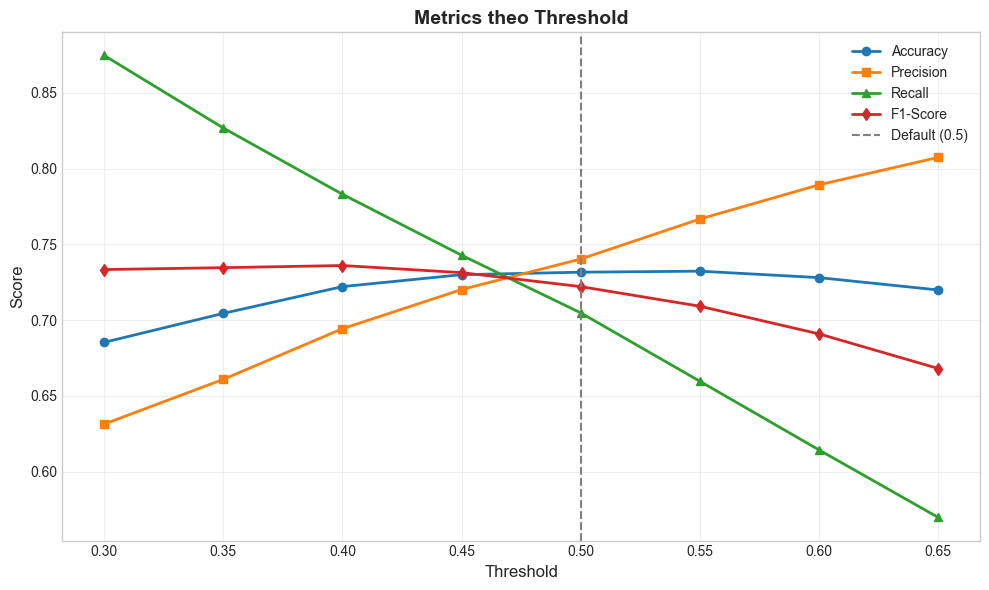


Threshold toi uu (Recall >= 0.75): 0.40
  Recall: 0.7831
  F1: 0.7360


In [40]:
# Visualization threshold optimization
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(thresh_df['threshold'], thresh_df['accuracy'], 'o-', label='Accuracy', linewidth=2)
ax.plot(thresh_df['threshold'], thresh_df['precision'], 's-', label='Precision', linewidth=2)
ax.plot(thresh_df['threshold'], thresh_df['recall'], '^-', label='Recall', linewidth=2)
ax.plot(thresh_df['threshold'], thresh_df['f1'], 'd-', label='F1-Score', linewidth=2)

ax.axvline(x=0.5, color='gray', linestyle='--', label='Default (0.5)')

ax.set_xlabel('Threshold', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Metrics theo Threshold', fontsize=14, fontweight='bold')
ax.legend(loc='best')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('outputs/20_threshold_optimization.png', dpi=150, bbox_inches='tight')
plt.show()

# Tim threshold toi uu cho Recall > 0.75
high_recall = thresh_df[thresh_df['recall'] >= 0.75]
if len(high_recall) > 0:
    best_thresh = high_recall.loc[high_recall['f1'].idxmax()]
    print(f"\nThreshold toi uu (Recall >= 0.75): {best_thresh['threshold']:.2f}")
    print(f"  Recall: {best_thresh['recall']:.4f}")
    print(f"  F1: {best_thresh['f1']:.4f}")

## 6. Tao bang tong ket cho bao cao

In [41]:
# Bang 1: So sanh Single Models
print("\n" + "="*70)
print("BANG 1: KET QUA CAC SINGLE MODELS")
print("="*70)
single_summary = single_results[['accuracy', 'precision', 'recall', 'f1', 'roc_auc']].round(4)
print(single_summary.to_string())


BANG 1: KET QUA CAC SINGLE MODELS
                    accuracy  precision  recall      f1  roc_auc
SGD                   0.7274     0.7321  0.7081  0.7199      NaN
DecisionTree          0.7253     0.7267  0.7130  0.7198   0.7811
MLP                   0.7288     0.7391  0.6985  0.7182   0.7979
KNN                   0.7201     0.7325  0.6841  0.7075   0.7814
LogisticRegression    0.7262     0.7543  0.6623  0.7053   0.7908
NaiveBayes            0.7205     0.7755  0.6123  0.6843   0.7851


In [42]:
# Bang 2: So sanh Ensemble Models
print("\n" + "="*70)
print("BANG 2: KET QUA CAC ENSEMBLE MODELS")
print("="*70)
ensemble_summary = ensemble_clean[['accuracy', 'precision', 'recall', 'f1', 'roc_auc']].round(4)
print(ensemble_summary.to_string())


BANG 2: KET QUA CAC ENSEMBLE MODELS
                 accuracy  precision  recall      f1  roc_auc
Stacking_Single    0.7316     0.7404  0.7048  0.7221   0.7982
XGBoost            0.7341     0.7529  0.6885  0.7192   0.7998
Blending           0.7329     0.7498  0.6906  0.7190   0.7998
NystroemSGD        0.7281     0.7363  0.7020  0.7187      NaN
BaggingSVM         0.7330     0.7511  0.6885  0.7184   0.7924
Stacking           0.7321     0.7486  0.6904  0.7183   0.7999
HardVoting         0.7332     0.7525  0.6865  0.7180      NaN
LightGBM           0.7325     0.7514  0.6865  0.7175   0.7996
SoftVoting         0.7321     0.7513  0.6855  0.7169   0.7997
RandomForest       0.7291     0.7483  0.6818  0.7135   0.7971
Voting_Single      0.7273     0.7669  0.6447  0.7005   0.7974


In [43]:
# Bang 3: Ablation Study
print("\n" + "="*70)
print("BANG 3: KET QUA ABLATION STUDY")
print("="*70)
ablation_summary = ablation_results[['accuracy', 'recall', 'f1']].round(4)
print(ablation_summary.to_string())


BANG 3: KET QUA ABLATION STUDY
                       accuracy  recall      f1
Full (All 4 models)      0.7311  0.6812  0.7148
Without LR               0.7321  0.6855  0.7169
Without RF               0.7307  0.6806  0.7143
Without XGB              0.7308  0.6794  0.7140
Without LGBM             0.7311  0.6810  0.7147
Only Top 2 (XGB+LGBM)    0.7333  0.6877  0.7184
Without ap_hi            0.7315  0.6820  0.7154
Without ap_lo            0.7318  0.6857  0.7167
Without age_years        0.7275  0.6484  0.7019
Without bmi              0.7312  0.6834  0.7155
Without cholesterol      0.7252  0.6875  0.7123


In [44]:
# Luu cac bang
single_summary.to_csv('outputs/table1_single_models.csv')
ensemble_summary.to_csv('outputs/table2_ensemble_models.csv')
ablation_summary.to_csv('outputs/table3_ablation.csv')

print("\nDa luu cac bang:")
print("  outputs/table1_single_models.csv")
print("  outputs/table2_ensemble_models.csv")
print("  outputs/table3_ablation.csv")


Da luu cac bang:
  outputs/table1_single_models.csv
  outputs/table2_ensemble_models.csv
  outputs/table3_ablation.csv


## 7. Export Final Model cho ung dung

In [45]:
# Luu final model voi metadata
final_model_package = {
    'model': best_model,
    'model_name': best_name,
    'feature_names': list(feature_names),
    'metrics': {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_proba)
    },
    'scaler_path': 'models/scaler.pkl',
    'threshold': 0.5
}

joblib.dump(final_model_package, 'models/final_model_package.pkl')
print("Da luu final model package: models/final_model_package.pkl")

Da luu final model package: models/final_model_package.pkl


In [46]:
# Tao ham predict de su dung trong ung dung
def predict_heart_disease(patient_data, model_path='models/final_model_package.pkl'):
    """
    Du doan benh tim cho benh nhan moi.
    
    Parameters:
    -----------
    patient_data : dict
        Thong tin benh nhan voi cac key:
        - age_years: Tuoi (nam)
        - gender: Gioi tinh (1: Nu, 2: Nam)
        - height: Chieu cao (cm)
        - weight: Can nang (kg)
        - ap_hi: Huyet ap tam thu
        - ap_lo: Huyet ap tam truong
        - cholesterol: Muc cholesterol (1, 2, 3)
        - gluc: Muc glucose (1, 2, 3)
        - smoke: Hut thuoc (0, 1)
        - alco: Uong ruou (0, 1)
        - active: Hoat dong the chat (0, 1)
    
    Returns:
    --------
    dict: Ket qua du doan
    """
    import joblib
    import numpy as np
    
    # Load model
    package = joblib.load(model_path)
    model = package['model']
    feature_names = package['feature_names']
    scaler = joblib.load(package['scaler_path'])
    
    # Tinh cac derived features
    bmi = patient_data['weight'] / ((patient_data['height'] / 100) ** 2)
    pulse_pressure = patient_data['ap_hi'] - patient_data['ap_lo']
    map_value = (patient_data['ap_hi'] + 2 * patient_data['ap_lo']) / 3
    
    # Tao feature vector
    features = np.array([[
        patient_data['age_years'],
        patient_data['gender'],
        patient_data['height'],
        patient_data['weight'],
        patient_data['ap_hi'],
        patient_data['ap_lo'],
        patient_data['cholesterol'],
        patient_data['gluc'],
        patient_data['smoke'],
        patient_data['alco'],
        patient_data['active'],
        bmi,
        pulse_pressure,
        map_value
    ]])
    
    # Scale features
    features_to_scale_idx = [0, 2, 3, 4, 5, 11, 12, 13]
    features_scaled = features.copy()
    features_scaled[:, features_to_scale_idx] = scaler.transform(features[:, features_to_scale_idx])
    
    # Predict
    prediction = model.predict(features_scaled)[0]
    probability = model.predict_proba(features_scaled)[0, 1]
    
    return {
        'prediction': int(prediction),
        'label': 'Co nguy co benh tim' if prediction == 1 else 'Khong co nguy co',
        'probability': float(probability),
        'risk_level': 'Cao' if probability > 0.7 else 'Trung binh' if probability > 0.5 else 'Thap'
    }

print("Da dinh nghia ham predict_heart_disease()")

Da dinh nghia ham predict_heart_disease()


In [49]:
# Test thu ham predict
example_patient = {
    'age_years': 55,
    'gender': 2,  # Nam
    'height': 170,
    'weight': 85,
    'ap_hi': 150,  # Huyet ap cao
    'ap_lo': 95,
    'cholesterol': 2,  # Cao
    'gluc': 1,  # Binh thuong
    'smoke': 1,  # Hut thuoc
    'alco': 0,
    'active': 0  # Khong tap the duc
}

print("\nVD Du doan cho benh nhan:")
print(f"  Tuoi: {example_patient['age_years']}, Nam")
print(f"  Chieu cao/Can nang: {example_patient['height']}cm / {example_patient['weight']}kg")
print(f"  Huyet ap: {example_patient['ap_hi']}/{example_patient['ap_lo']}")
print(f"  Cholesterol: Cao, Hut thuoc: Co")

result = predict_heart_disease(example_patient)
print(f"\nKet qua: {result['label']}")
print(f"Xac suat: {result['probability']:.2%}")
print(f"Muc do nguy co: {result['risk_level']}")


VD Du doan cho benh nhan:
  Tuoi: 55, Nam
  Chieu cao/Can nang: 170cm / 85kg
  Huyet ap: 150/95
  Cholesterol: Cao, Hut thuoc: Co

Ket qua: Co nguy co benh tim
Xac suat: 86.99%
Muc do nguy co: Cao


## 8. Tong ket cuoi cung

In [48]:
print("\n" + "="*70)
print("TONG KET DU AN CHAN DOAN BENH TIM BANG ENSEMBLE MODEL")
print("="*70)

print("\n1. DU LIEU:")
print("   - Dataset: Cardiovascular Disease")
print("   - So mau: ~70,000")
print("   - Features: 14 (bao gom derived features)")
print("   - Chia du lieu: 70/15/15 (Train/Val/Test)")

print("\n2. SINGLE MODELS (6 models):")
print("   - Logistic Regression, KNN, Naive Bayes, Decision Tree")
print("   - MLP Classifier, SGDClassifier (Linear SVM)")
print("   - Hyperparameter tuning: Optuna (50 trials)")
print("   - Cross-validation: 5-Fold Stratified")

print("\n3. ENSEMBLE MODELS:")
print("   Base Ensemble: RF, XGB, LightGBM, Bagging SVM, Nystroem+SGD")
print("   Advanced: Hard Voting, Soft Voting")
print("   - Stacking (LR meta, XGB meta), Blending")

print(f"\n4. BEST MODEL: {best_name}")
best_metrics = ensemble_results.loc[ensemble_results['f1'].idxmax()]
print(f"   - Accuracy:  {best_metrics['accuracy']:.4f}")
print(f"   - Precision: {best_metrics['precision']:.4f}")
print(f"   - Recall:    {best_metrics['recall']:.4f}")
print(f"   - F1-Score:  {best_metrics['f1']:.4f}")
print(f"   - ROC-AUC:   {best_metrics['roc_auc']:.4f}")

print("\n5. ABLATION STUDY:")
print("   - Chung minh moi base model deu dong gop vao ket qua")
print("   - Features quan trong nhat: ap_hi, ap_lo, age_years, bmi")

print("\n6. FILES DA TAO:")
print("   - Notebooks: 01_EDA, 02_Preprocessing, 03_SingleModels, 04_EnsembleModels, 05_Evaluation")
print("   - Models: models/final_model_package.pkl")
print("   - Outputs: 20+ bieu do va bang ket qua")

print("\n" + "="*70)
print("DU AN HOAN THANH!")
print("="*70)


TONG KET DU AN CHAN DOAN BENH TIM BANG ENSEMBLE MODEL

1. DU LIEU:
   - Dataset: Cardiovascular Disease
   - So mau: ~70,000
   - Features: 14 (bao gom derived features)
   - Chia du lieu: 70/15/15 (Train/Val/Test)

2. SINGLE MODELS (6 models):
   - Logistic Regression, KNN, Naive Bayes, Decision Tree
   - MLP Classifier, SGDClassifier (Linear SVM)
   - Hyperparameter tuning: Optuna (50 trials)
   - Cross-validation: 5-Fold Stratified

3. ENSEMBLE MODELS:
   Base Ensemble: RF, XGB, LightGBM, Bagging SVM, Nystroem+SGD
   Advanced: Hard Voting, Soft Voting
   - Stacking (LR meta, XGB meta), Blending

4. BEST MODEL: Stacking_Single
   - Accuracy:  0.7316
   - Precision: 0.7404
   - Recall:    0.7048
   - F1-Score:  0.7221
   - ROC-AUC:   0.7982

5. ABLATION STUDY:
   - Chung minh moi base model deu dong gop vao ket qua
   - Features quan trong nhat: ap_hi, ap_lo, age_years, bmi

6. FILES DA TAO:
   - Notebooks: 01_EDA, 02_Preprocessing, 03_SingleModels, 04_EnsembleModels, 05_Evaluation
 